**Стогний Е.А. М22-Ш02**
Лаб. 1

# **Лабораторная работа**


**Лабораторная работа. Применение алгоритмов Process mining для анализа журналов событий**

Цель: изучение алгоритмов Process mining для анализа журналов событий и поиска "узких мест" в системе по журналу.

Для выполнения работы используются язык Python и библиотеки PM4PY, Pandas.

**Начало работы. Чтение журнала событий**

Библиотека pm4py работает как с форматами данных CSV (стандарт файлов для Pandas), так и с форматами XES — это стандартный формат, используемый для хранения журналов событий.

Два соответствующих форматов в модуле есть два метода:

- converter из pm4py.objects.conversion.log (здесь псевдоним log_converter), который преобразует стандартные фреймы данных pandas в журналы событий;
- importer из pm4py.objects.log.importer.xes (здесь псевдоним xes_importer), который импортирует журналы. в формате XES.

Для того, чтобы считать файл в формате .csv для дальнейшей работы, сначала необходимо его импортировать с помощью библиотеки pandas в DataFrame. Далее с помощью метода библиотеки pm4py.objects.conversion.log.converter преобразуем его в журнал событий.

In [288]:
# Установка библиотеки для Process mining
!pip install pm4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [289]:
# Импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

In [290]:
# Считывание файла в формате .csv

# 1. Считываем сначала наши данные с помощью библиотеки Pandas в DataFrame
log_csv = pd.read_csv('https://raw.githubusercontent.com/Adelaaas/Process_mining_lab_hes/main/ArtificialPatientTreatment.csv')

log_csv

,patient,action,org:resource,DateTime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09
...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13


In [291]:
type(log_csv)

pandas.core.frame.DataFrame

Перед началом работы с любым набором данных, необходимо сначала его изучить:

- названия колонок
- типы данных
- пропущенные значения
- и другое

In [292]:
log_csv.columns

Index(['patient', ' action', ' org:resource', ' DateTime'], dtype='object')

In [293]:
# Преобразуем тип данных в колонке DateTime в специальных формат даты и времени библиотеки Pandas
log_csv[' DateTime'] = pd.to_datetime(log_csv[' DateTime'])

log_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   patient        690 non-null    object        
 1    action        690 non-null    object        
 2    org:resource  690 non-null    object        
 3    DateTime      690 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 21.7+ KB


In [294]:
# Создаем сгруппированную таблицу с начальной отметкой времени и конечной для каждого case
case_starts_ends = log_csv.pivot_table(index='patient', aggfunc={' DateTime': ['min', 'max']}) 

case_starts_ends

DateTime                    
                           max                 min
patient                                           
patient 0  2017-01-09 08:29:28 2017-01-02 11:40:11
patient 1  2017-01-06 16:49:21 2017-01-02 12:50:35
patient 10 2017-01-30 11:19:19 2017-01-17 14:13:17
patient 11 2017-02-02 10:13:13 2017-01-19 13:35:20
patient 12 2017-01-27 11:18:57 2017-01-20 11:43:38
...                        ...                 ...
patient 95 2017-05-26 10:19:34 2017-05-15 09:15:08
patient 96 2017-05-24 16:38:21 2017-05-15 10:31:45
patient 97 2017-05-22 14:37:56 2017-05-17 08:44:01
patient 98 2017-05-31 14:16:13 2017-05-17 10:56:48
patient 99 2017-05-31 12:46:43 2017-05-18 11:57:11

[100 rows x 2 columns]

In [295]:
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart'] 
# Merge with the main event log data so that for each row we have the start and end times.
log_csv = log_csv.merge(case_starts_ends, on='patient') 
# Calculate the relative time by subtracting the process start time from the event timestamp
log_csv['relativetime'] = log_csv[' DateTime'] - log_csv['casestart']
# Convert relative times to more friendly measures
## seconds
log_csv['relativetime_s'] = log_csv['relativetime'].dt.seconds + 86400*log_csv['relativetime'].dt.days 
## days
log_csv['relativedays'] = log_csv['relativetime'].dt.days

log_csv

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3
...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11


In [296]:
log_csv['caselength'] = log_csv['caseend'] - log_csv['casestart']

log_csv

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32


<Axes: xlabel='relativetime_s', ylabel='patient'>

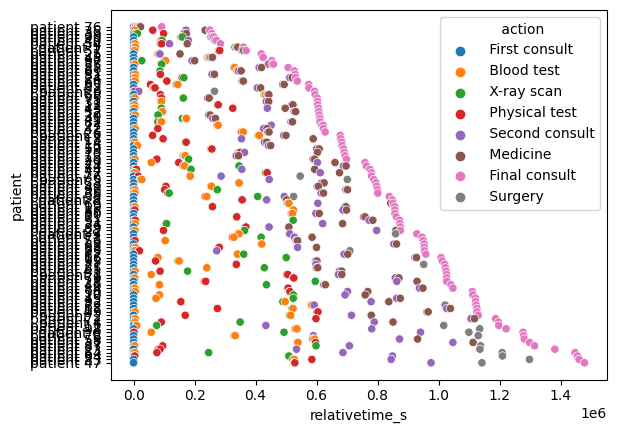

In [297]:
## Order by the case length
ordered = log_csv.sort_values(by=['caselength', 'patient', 'relativetime_s'])

# plt.figure(figsize=(15,15))
sns.scatterplot(x=ordered['relativetime_s'], y=ordered['patient'], hue=ordered[' action'])

In [298]:
patient_events = pd.crosstab(log_csv['patient'], log_csv[' action']) 
patient_events

action,Blood test,Final consult,First consult,Medicine,Physical test,Second consult,Surgery,X-ray scan
patient,,,,,,,,
patient 0,1,1,1,0,1,1,1,0
patient 1,1,1,1,1,1,1,0,1
patient 10,1,1,1,1,1,1,0,1
patient 11,1,1,1,0,1,1,1,1
patient 12,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...
patient 95,1,1,1,0,1,1,1,0
patient 96,1,1,1,1,1,1,0,1
patient 97,1,1,1,1,1,1,0,1


In [299]:
len(log_csv['patient'].unique())

100

In [300]:
patient_events.sum()

 action
 Blood test        100
 Final consult     100
 First consult     100
 Medicine           80
 Physical test     100
 Second consult    100
 Surgery            20
 X-ray scan         90
dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, ' First consult'),
  Text(1, 0, ' Blood test'),
  Text(2, 0, ' Physical test'),
  Text(3, 0, ' Second consult'),
  Text(4, 0, ' Surgery'),
  Text(5, 0, ' Final consult'),
  Text(6, 0, ' X-ray scan'),
  Text(7, 0, ' Medicine')])

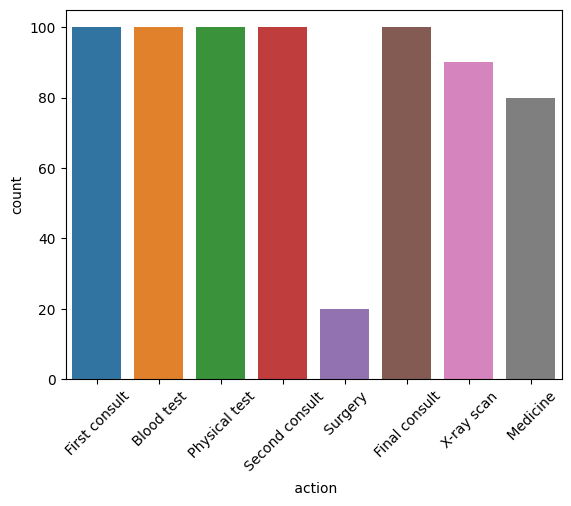

In [301]:
sns.countplot(x=log_csv[' action'])
plt.xticks(rotation=45)

In [302]:
patient_events.sum(axis=1)

patient
patient 0     6
patient 1     7
patient 10    7
patient 11    7
patient 12    7
             ..
patient 95    6
patient 96    7
patient 97    7
patient 98    7
patient 99    7
Length: 100, dtype: int64

Для работы с журналом событий Process mining определяет основные атрибуты событий в журналах:

- Идентификатор случая (case id): хранит случаи (объекты), для которых выстраиваются последовательности событий журнала.
- Деятельность (activity name): хранит действия, выполняемые в рамках событий журнала.
- Отметка времени (timestamp): хранит дату и время регистрации событий журнала.
- Ресурс (resource): хранит основных действующих лиц событий журнала (тех, кто выполняет действия в рамках событий журнала).
- Прочее (other data): сюда попадает вся оставшаяся в журнале (не интересная нам) информация.

В данной задаче за Case id обозначаем отдельного пациента, а за activity name обозначаем все действия пациентов.

In [303]:
# 2. Переименуем колонки в соответсвии с требованиями Process mining
log_csv.rename(columns=
                {' DateTime': 'time:timestamp',
                 'patient': 'case:concept:name',
                 ' action': 'concept:name',
                 ' org:resource': 'org:resource'},
                inplace=True)

log_csv

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32


In [304]:
# 3. Преобразуем DataFrame в формат журнала Process mining
event_log = log_converter.apply(log_csv)

# Видим, что теперь тип наших данных EventLog
type(event_log)

pm4py.objects.log.obj.EventLog

In [305]:
event_log

[{'attributes': {'concept:name': 'patient 0'}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Anna', 'time:timestamp': Timestamp('2017-01-02 11:40:11'), 'caseend': Timestamp('2017-01-09 08:29:28'), 'casestart': Timestamp('2017-01-02 11:40:11'), 'relativetime': Timedelta('0 days 00:00:00'), 'relativetime_s': 0, 'relativedays': 0, 'caselength': Timedelta('6 days 20:49:17')}, '..', {'concept:name': ' Final consult', 'org:resource': ' Dr. Ben', 'time:timestamp': Timestamp('2017-01-09 08:29:28'), 'caseend': Timestamp('2017-01-09 08:29:28'), 'casestart': Timestamp('2017-01-02 11:40:11'), 'relativetime': Timedelta('6 days 20:49:17'), 'relativetime_s': 593357, 'relativedays': 6, 'caselength': Timedelta('6 days 20:49:17')}]}, '....', {'attributes': {'concept:name': 'patient 99'}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Bob', 'time:timestamp': Timestamp('2017-05-18 11:57:11'), 'caseend': Timestamp('2017-05-31 12:46:43'), 'casestart': Timestamp('20

In [306]:
log_csv.shape

(690, 10)

In [307]:
# Количество различных событий в нашем журнале событий

len(log_csv)

690

In [308]:
# Количество всех кейсов в нашем журнале событий

len(event_log)

100

In [309]:
len(event_log[0])

6

Важно! помнить что кейс состоит из набора различных событий, которые относятся к одному пациенту.

Используя библиотеки PM4Py и Pandas можно исследовать имещейся журнал событий с разных сторон.

Например, посмотреть частотные признаки по врачам.

In [310]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log_csv, "org:resource")
activities

{' Dr. Anna': 158,
 ' Lab': 100,
 ' Nurse Jesse': 57,
 ' Dr. Charlie': 5,
 ' Dr. Ben': 50,
 ' Team 1': 40,
 ' Pharmacy': 80,
 ' Team 2': 50,
 ' Nurse Corey': 43,
 ' Dr. Bob': 92,
 ' Dr. Rudy': 7,
 ' Dr. Alex': 5,
 ' Dr. Quinn': 3}

In [311]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log_csv, 'concept:name')
activities

{' First consult': 100,
 ' Blood test': 100,
 ' Physical test': 100,
 ' Second consult': 100,
 ' Surgery': 20,
 ' Final consult': 100,
 ' X-ray scan': 90,
 ' Medicine': 80}

Также можно посмотреть на различные вариации событий в различных кейсах и насколько они совпадают или различаются.

Вариант — это набор кейсов, которые имеют одну и ту же перспективу потока управления, то есть набор кейсов, которые используют одни и те же события в одном и том же порядке. Для исследования различных вариантов существует метод библиотеки PM4PY

In [312]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics

variants = variants_filter.get_variants(event_log)
print(f"У нас есть: {len(variants)} различных вариантов путей в нашем журнале событий")

У нас есть: 15 различных вариантов путей в нашем журнале событий


In [313]:
# можно посмотреть на рэти различные варианты
# 'count' - сколько данные набор событий в такой последовательности встречается в журнале событий
# 'variant' - набор этих действий и их последовательность
# всего 15 словарей - так как 15 вариантов
variants_count = case_statistics.get_variant_statistics(log_csv)

variants_count

[{'variant': (' First consult',
   ' Blood test',
   ' X-ray scan',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 18},
 {'variant': (' First consult',
   ' Blood test',
   ' Physical test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 14},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Physical test',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 12},
 {'variant': (' First consult',
   ' Physical test',
   ' X-ray scan',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 11},
 {'variant': (' First consult',
   ' Physical test',
   ' Blood test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 10},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Blood test',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 9},
 {'variant'

**Построение модели по журналу событий**

**Alpha Miner**

Alpha miner — один из самых известных алгоритмов интеллектуального анализа процессов и один из первых алгоритмов, способных обнаруживать параллелизм. Алгоритм использует прямую последовательность , причинно -следственные , параллельные и несвязанные отношения между переходами в журнале для обнаружения сети рабочего процесса.

http://mlwiki.org/index.php/Alpha_Algorithm

In [314]:
# Импортируем алгоритм из библиотеки PM4PY
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

# Создаем алгоритм
net, initial_marking, final_marking = alpha_miner.apply(event_log)

Полученный процесс мы можем отобразить с помощью Сетей Петри.

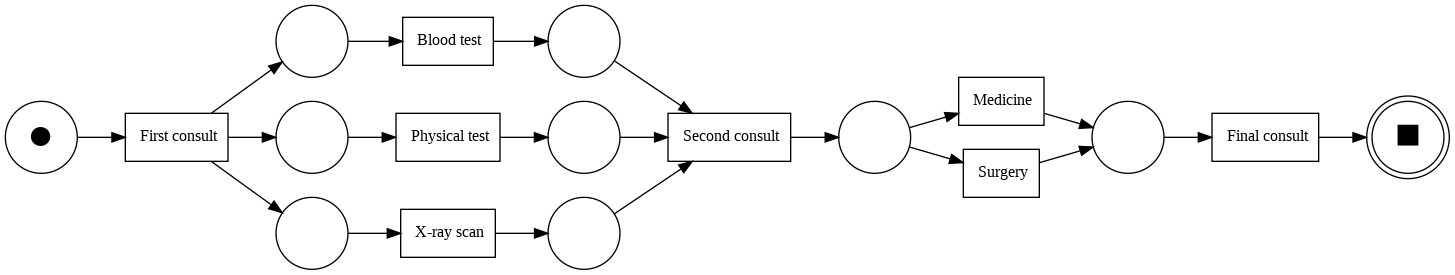

In [315]:
# Импортируем метод визуализации Сетей Петри из библиотеки PM4Py
from pm4py.visualization.petri_net import visualizer as pn_visualizer

gviz = pn_visualizer.apply(net, initial_marking, final_marking)

pn_visualizer.view(gviz)

Чтобы получить представление о частоте переходов, можно установить параметр pn_visualizer.Variants.FREQUENCY при вызове pn_visualizer.apply().

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

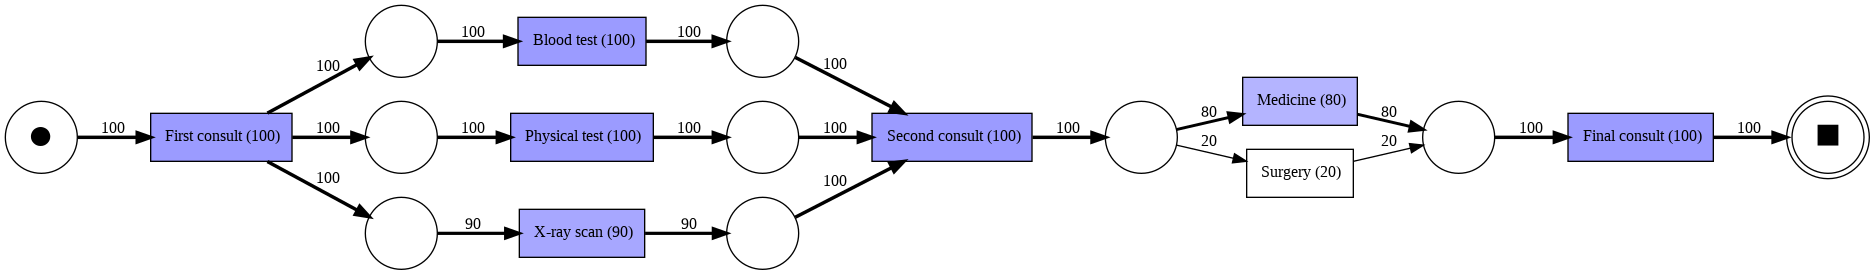

In [316]:
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

gviz = pn_visualizer.apply(net, initial_marking,
                           final_marking,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)

pn_visualizer.view(gviz)

In [317]:
# Полученные модели процессов можно сохранить

pn_visualizer.save(gviz, "alpha_miner_lab.png")

Функция get_transition_performance_with_token_replay принимает журнал событий, представление сети Петри обнаруженной модели процесса, а также начальные и конечные маркировки, которые мы хотим учитывать в модели. Он возвращает словарь, содержащий показатели производительности (значения словаря), связанные с каждым из Activity (ключи словаря).

Словарь содержит как все значения для данного Activity, а также среднее значение, медиану, максимум и минимум по времени на данное действие. Анализируя полученые traces можно посчитать различное время отдельных событий.

In [318]:
from pm4py.visualization.petri_net.util import performance_map
# pm4py.objects.petri.performance_map.get_transition_performance_with_token_replay

traces = performance_map.get_transition_performance_with_token_replay(event_log,
                                                                      net,
                                                                      initial_marking,
                                                                      final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

In [319]:
traces.keys()

dict_keys(["( First consult, ' First consult')", "( Blood test, ' Blood test')", "( Physical test, ' Physical test')", "( X-ray scan, ' X-ray scan')", "( Second consult, ' Second consult')", "( Medicine, ' Medicine')", "( Surgery, ' Surgery')", "( Final consult, ' Final consult')"])

In [320]:
log_csv[log_csv['case:concept:name'] == 'patient 13']

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
89,patient 13,First consult,Dr. Bob,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,0 days 00:00:00,0,0,8 days 00:40:34
90,patient 13,X-ray scan,Team 2,2017-01-25 12:29:05,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 21:19:55,163195,1,8 days 00:40:34
91,patient 13,Physical test,Nurse Jesse,2017-01-25 13:34:31,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 22:25:21,167121,1,8 days 00:40:34
92,patient 13,Blood test,Lab,2017-01-25 14:25:04,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 23:15:54,170154,1,8 days 00:40:34
93,patient 13,Second consult,Dr. Anna,2017-01-27 12:37:29,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 21:28:19,336499,3,8 days 00:40:34
94,patient 13,Medicine,Pharmacy,2017-01-27 14:47:02,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 23:37:52,344272,3,8 days 00:40:34
95,patient 13,Final consult,Dr. Ben,2017-01-31 15:49:44,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34,693634,8,8 days 00:40:34


<Axes: xlabel='time:timestamp', ylabel='org:resource'>

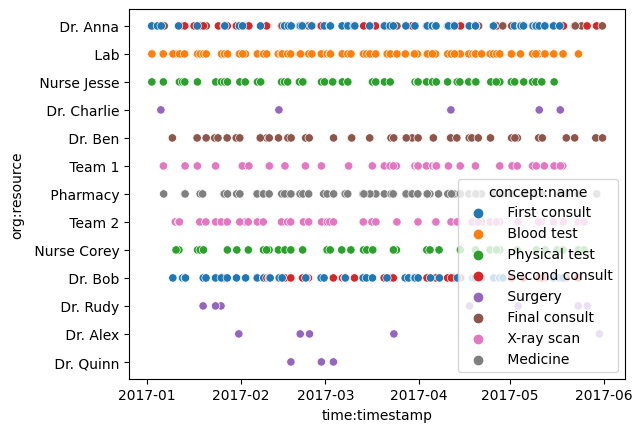

In [321]:
sns.scatterplot(x=log_csv['time:timestamp'], y=log_csv['org:resource'], hue=log_csv['concept:name'])

# **Домашнее задание**

**Задания. Изучение журнала событий**

1.Каково минимальное и максимальное количество событий в одном случае?

2.Какие события являются общими для всех процессов?

3.Найдите наибоее часто встречающуюся последовательность событий.

4.Какой пациент на лечение тратил меньше всего времени, а какой больше?

5.Создать в DataFrame новую колонку, в которой будет записано количество событий для данного процесса (NumActions in Case)

6.Pation 13 с каким врачом/врачами он/она консультировался?

7.Какое событие является наиболее ресурсоёмким в данном журнале событий?

8.Есть ли врачи или медсестры, которые перегружены работой?

9.Какие мероприятия (actions) непропорционально отнимают время у некоторых врачей и медсестер? Каково распределение событий среди врачей и медсестер?

10.Какие события связаны с узкими местами и какие ресурсы задействованы?

11.Постройте график/и распределения времени между первой консультацией и следующим действием пациента. Каково среднее время между первой консультацией и следующим шагом лечения? Каково максимальное и минимальное время?

12.Используя библиотеки PM4PY и networkx, создайте граф социальных связей по данному журналу событий, используя метрику SNA.

Документация: https://pm4py.fit.fraunhofer.de/documentation#social-network-analysis

**1. Каково минимальное и максимальное количество событий в одном случае?**

In [322]:
concept_grouped = log_csv.groupby('case:concept:name').count()['concept:name']
concept_grouped

case:concept:name
patient 0     6
patient 1     7
patient 10    7
patient 11    7
patient 12    7
             ..
patient 95    6
patient 96    7
patient 97    7
patient 98    7
patient 99    7
Name: concept:name, Length: 100, dtype: int64

In [323]:
min_event = min(concept_grouped)
max_event = max(concept_grouped)
print(f"Минимальное число событий: {min_event}, Максимальное число событий: {max_event}")

Минимальное число событий: 6, Максимальное число событий: 7


Минимальное число событий 6, а максимальное - 7. Все пациенты проходили либо 6, либо 7 процедур.

**2.Какие события являются общими для всех процессов?**

In [324]:
patient_events

action,Blood test,Final consult,First consult,Medicine,Physical test,Second consult,Surgery,X-ray scan
patient,,,,,,,,
patient 0,1,1,1,0,1,1,1,0
patient 1,1,1,1,1,1,1,0,1
patient 10,1,1,1,1,1,1,0,1
patient 11,1,1,1,0,1,1,1,1
patient 12,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...
patient 95,1,1,1,0,1,1,1,0
patient 96,1,1,1,1,1,1,0,1
patient 97,1,1,1,1,1,1,0,1


In [325]:
print("Общие события для всех процессов:\n")

for column in patient_events.columns.values:
    if (patient_events[column] == 1).all():
        print(f"{column}")

Общие события для всех процессов:

 Blood test
 Final consult
 First consult
 Physical test
 Second consult


**3.Найдите наибоее часто встречающуюся последовательность событий.**

На основании variants_count - списка с последовательностью и её частотой встречаемости, можем увидеть, что есть некоторая последовательность, которая встречаеся у 18 пациентов (она и есть самая частовстречающаяся).

In [326]:
counts = [var['count'] for var in variants_count]
counts

[18, 14, 12, 11, 10, 9, 4, 4, 3, 3, 3, 3, 2, 2, 2]

In [327]:
vars = [var['variant'] for var in variants_count]
print(f"Наиболее часто встречающиеся последовательности: {vars[0]}")

Наиболее часто встречающиеся последовательности: (' First consult', ' Blood test', ' X-ray scan', ' Physical test', ' Second consult', ' Medicine', ' Final consult')


**4.Какой пациент на лечение тратил меньше всего времени, а какой больше?**

На основании таблицы с началом и концом событий, рассчитываем, сколько каждый пациент пробыл в больнице.

In [328]:
case_starts_ends['case_length'] = case_starts_ends['caseend'] - case_starts_ends['casestart']
case_starts_ends

,patient,caseend,casestart,case_length
0,patient 0,2017-01-09 08:29:28,2017-01-02 11:40:11,6 days 20:49:17
1,patient 1,2017-01-06 16:49:21,2017-01-02 12:50:35,4 days 03:58:46
2,patient 10,2017-01-30 11:19:19,2017-01-17 14:13:17,12 days 21:06:02
3,patient 11,2017-02-02 10:13:13,2017-01-19 13:35:20,13 days 20:37:53
4,patient 12,2017-01-27 11:18:57,2017-01-20 11:43:38,6 days 23:35:19
...,...,...,...,...
95,patient 95,2017-05-26 10:19:34,2017-05-15 09:15:08,11 days 01:04:26
96,patient 96,2017-05-24 16:38:21,2017-05-15 10:31:45,9 days 06:06:36
97,patient 97,2017-05-22 14:37:56,2017-05-17 08:44:01,5 days 05:53:55
98,patient 98,2017-05-31 14:16:13,2017-05-17 10:56:48,14 days 03:19:25


Найдем, какой пациент провел большего всего времени в больнице, а какой - меньше.

In [329]:
min_time = min(case_starts_ends['case_length'])
max_time = max(case_starts_ends['case_length'])

In [330]:
print(f"Больше всего времени провел в больница пациент {(case_starts_ends[case_starts_ends['case_length'] == max_time]['patient']).values[0]}: \nдней: {max_time.days}\nчасов: {max_time.seconds // 3600}\nминут: {(max_time.seconds // 60) % 60}")

Больше всего времени провел в больница пациент patient 47: 
дней: 17
часов: 2
минут: 43


In [331]:
print(f"Меньше всего времени провел в больница пациент {(case_starts_ends[case_starts_ends['case_length'] == min_time]['patient']).values[0]}: \nдней: {min_time.days}\nчасов: {min_time.seconds // 3600}\nминут: {(min_time.seconds // 60) % 60}")

Меньше всего времени провел в больница пациент patient 76: 
дней: 1
часов: 1
минут: 34


**5. Создать в DataFrame новую колонку, в которой будет записано количество событий для данного процесса (NumActions in Case)**

In [332]:
log_csv['NumActions in Case'] = log_csv.groupby('case:concept:name').cumcount() + 1
log_csv

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17,1
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17,2
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17,3
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17,4
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17,5
...,...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32,3
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32,4
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32,5
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32,6


**6. Pation 13 с каким врачом/врачами он/она консультировался?**

In [333]:
print(f"Patient 13 консультировался (-лась) с врачами: {log_csv[log_csv['case:concept:name'] == 'patient 13']['org:resource'].values}")

Patient 13 консультировался (-лась) с врачами: [' Dr. Bob' ' Team 2' ' Nurse Jesse' ' Lab' ' Dr. Anna' ' Pharmacy'
 ' Dr. Ben']


**7. Какое событие является наиболее ресурсоёмким в данном журнале событий?**

Если рассматривать ресурсоемкость с позиции времени, то из таблицы видно, что наиболее ресурсоемким событием является Blood test (что логично, т.к. подготовка анализов является самым длительным процессом).

In [334]:
import numpy as np

log_csv['diff'] = log_csv.groupby('case:concept:name')['time:timestamp'].diff(1)
log_csv['time'] = log_csv.groupby('case:concept:name')['diff'].shift(-1)
log_csv.drop('diff', axis=1, inplace=True)

pd.pivot_table(log_csv, index=["concept:name", "org:resource"], values=["time"], aggfunc=['sum', 'count'])

sum count
                                          time  time
concept:name    org:resource                        
 Blood test      Lab         201 days 09:17:03   100
 Final consult   Dr. Anna      0 days 00:00:00     0
                 Dr. Ben       0 days 00:00:00     0
 First consult   Dr. Anna     69 days 07:46:45    53
                 Dr. Bob      85 days 08:23:39    47
 Medicine        Pharmacy    171 days 03:07:31    80
 Physical test   Nurse Corey  76 days 13:52:01    43
                 Nurse Jesse  93 days 03:03:55    57
 Second consult  Dr. Anna     57 days 17:50:57    55
                 Dr. Bob      51 days 02:00:11    45
 Surgery         Dr. Alex     13 days 10:53:25     5
                 Dr. Charlie   9 days 16:55:36     5
                 Dr. Quinn     2 days 19:43:52     3
                 Dr. Rudy     14 days 01:08:09     7
 X-ray scan      Team 1       52 days 14:33:43    40
                 Team 2       59 days 08:17:17    50

**8. Есть ли врачи или медсестры, которые перегружены работой?**

Выведем всех врачей и число их процедур

In [335]:
activities = attributes_filter.get_attribute_values(log_csv, "org:resource")
activities

{' Dr. Anna': 158,
 ' Lab': 100,
 ' Nurse Jesse': 57,
 ' Dr. Charlie': 5,
 ' Dr. Ben': 50,
 ' Team 1': 40,
 ' Pharmacy': 80,
 ' Team 2': 50,
 ' Nurse Corey': 43,
 ' Dr. Bob': 92,
 ' Dr. Rudy': 7,
 ' Dr. Alex': 5,
 ' Dr. Quinn': 3}

Также из таблицы в предыдущем задании посмотрим на длительность процедур, проведенных этими врачами. Можно увидеть, что наиболее перегруженные работой врачи - Dr. Anna (158 процедур и более 126 дней их выполнения, врачи лаборатории Lab - 100 процедур и более 201 дня её выполнения, Dr. Bob (92 процедуры и более 136 дней их выполнения), врачи из Pharmacy (171 процедура и 80 дней её выполнения).

**9. Какие мероприятия (actions) непропорционально отнимают время у некоторых врачей и медсестер? Каково распределение событий среди врачей и медсестер?**

Еще раз посмотрим на длительность процедур. Можно предпроложить, что непропорционально отнимают время те actions, которые долго (по сравнению с остальными процедурами) длятся при расчете на 1 процедуру, например, Blood test, Medicine (на 1 тест затрачивается более 2х дней). Также к таким actions можно отнести Surgery.

In [336]:
pd.pivot_table(log_csv, index=["concept:name", "org:resource"], values=["time"], aggfunc=['sum', 'count'])

sum count
                                          time  time
concept:name    org:resource                        
 Blood test      Lab         201 days 09:17:03   100
 Final consult   Dr. Anna      0 days 00:00:00     0
                 Dr. Ben       0 days 00:00:00     0
 First consult   Dr. Anna     69 days 07:46:45    53
                 Dr. Bob      85 days 08:23:39    47
 Medicine        Pharmacy    171 days 03:07:31    80
 Physical test   Nurse Corey  76 days 13:52:01    43
                 Nurse Jesse  93 days 03:03:55    57
 Second consult  Dr. Anna     57 days 17:50:57    55
                 Dr. Bob      51 days 02:00:11    45
 Surgery         Dr. Alex     13 days 10:53:25     5
                 Dr. Charlie   9 days 16:55:36     5
                 Dr. Quinn     2 days 19:43:52     3
                 Dr. Rudy     14 days 01:08:09     7
 X-ray scan      Team 1       52 days 14:33:43    40
                 Team 2       59 days 08:17:17    50

Посмотрим долю каждых врача/медсестры/группы

In [337]:
log_csv['org:resource'].value_counts() / log_csv['org:resource'].value_counts().sum()

 Dr. Anna       0.228986
 Lab            0.144928
 Dr. Bob        0.133333
 Pharmacy       0.115942
 Nurse Jesse    0.082609
 Dr. Ben        0.072464
 Team 2         0.072464
 Nurse Corey    0.062319
 Team 1         0.057971
 Dr. Rudy       0.010145
 Dr. Charlie    0.007246
 Dr. Alex       0.007246
 Dr. Quinn      0.004348
Name: org:resource, dtype: float64

  Исходя из таблиц, можно увидеть, что непосредственно только медсестры задействованы на Physical test. Доля действий медсестр составила 0.145 (0.083 + 0.062) от всех actions в этом журнале. В остальных действиях принимают участие либо только доктора, либо команды и иные мед. сотрудники. 
  То есть только медсестры выполняют одно мероприятие из 8 возможных, только доктора выполняют 4 мероприятия из 8 возможных, а команды или другие мед. сотрудники выполняют оставшиеся 3 мероприятия.

In [338]:
pd.crosstab(log_csv[log_csv['org:resource'].str.contains('')]['org:resource'], log_csv['concept:name'])

concept:name,Blood test,Final consult,First consult,Medicine,Physical test,Second consult,Surgery,X-ray scan
org:resource,,,,,,,,
Dr. Alex,0,0,0,0,0,0,5,0
Dr. Anna,0,50,53,0,0,55,0,0
Dr. Ben,0,50,0,0,0,0,0,0
Dr. Bob,0,0,47,0,0,45,0,0
Dr. Charlie,0,0,0,0,0,0,5,0
Dr. Quinn,0,0,0,0,0,0,3,0
Dr. Rudy,0,0,0,0,0,0,7,0
Lab,100,0,0,0,0,0,0,0
Nurse Corey,0,0,0,0,43,0,0,0


**10. Какие события связаны с узкими местами и какие ресурсы задействованы?**

In [339]:
long_active = log_csv.groupby('concept:name').agg({'time': 'mean', 'org:resource': lambda l: ",".join(l.unique())})
long_active.nlargest(3, 'time')

,time,org:resource
concept:name,,
Medicine,2 days 03:20:20.637500,Pharmacy
Blood test,2 days 00:19:58.230000,Lab
Surgery,2 days 00:02:03.100000,"Dr. Charlie, Dr. Rudy, Dr. Alex, Dr. Quinn"


Как уже было выяснено в задании 9, к узким местам можно отнести события, которые долго (по сравнению с остальными процедурами) длятся при расчете на 1 процедуру (Blood test, Medicine, Surgery).

**11. Постройте график/и распределения времени между первой консультацией и следующим действием пациента. Каково среднее время между первой консультацией и следующим шагом лечения? Каково максимальное и минимальное время?**

In [340]:
from pm4py.objects.petri_net.utils.performance_map import mean
import pm4py

first_to_next = pm4py.filter_event_attribute_values(log_csv, "NumActions in Case", [2], level="event", retain=True, )

mean_time = mean(first_to_next['relativetime_s'])
mean_hour = mean_time // 3600
mean_minutes = (mean_time // 60) % 60

max_time = max(first_to_next['relativetime_s'])
max_hour = max_time // 3600
max_minutes = (max_time // 60) % 60

min_time = min(first_to_next['relativetime_s'])
min_hour = min_time // 3600
min_minutes = (min_time // 60) % 60

print(f"Среднее время между первой консультацией и следующим шагом лечения: {mean_hour} часов {mean_minutes} минут")
print(f"Максимальное время между первой консультацией и следующим шагом лечения: {max_hour} часов {max_minutes} минут")
print(f"Минимальное время между первой консультацией и следующим шагом лечения: {min_hour} часов {min_minutes} минут")

Среднее время между первой консультацией и следующим шагом лечения: 37.0 часов 7.0 минут
Максимальное время между первой консультацией и следующим шагом лечения: 163 часов 5 минут
Минимальное время между первой консультацией и следующим шагом лечения: 0 часов 22 минут


Text(0, 0.5, 'Число пациентов')

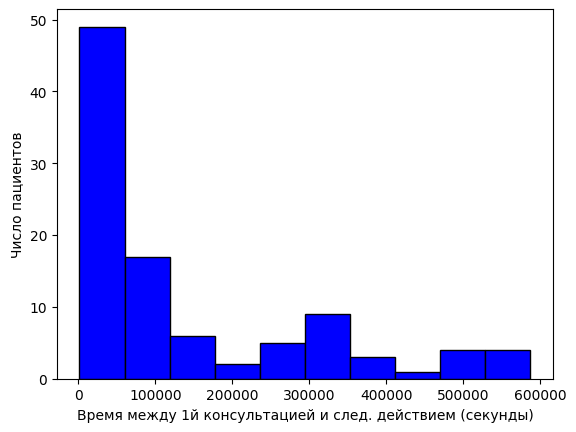

In [360]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(first_to_next['relativetime_s'], color = 'blue', edgecolor = 'black',)
plt.xlabel('Время между 1й консультацией и след. действием (секунды)')
plt.ylabel('Число пациентов')

Text(0, 0.5, 'Пациенты')

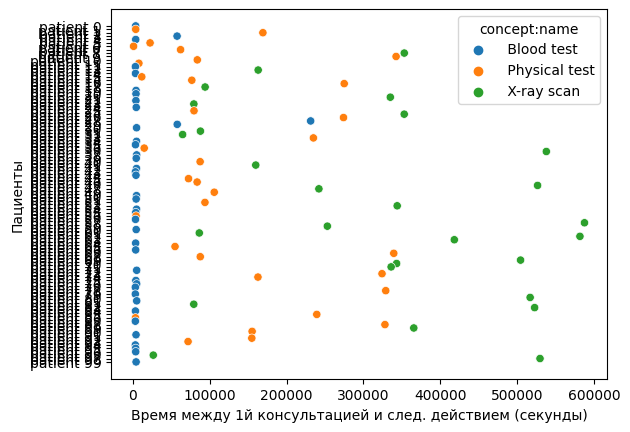

In [342]:
sns.scatterplot(x=first_to_next['relativetime_s'], y=first_to_next['case:concept:name'], hue=first_to_next['concept:name'])
plt.xlabel('Время между 1й консультацией и след. действием (секунды)')
plt.ylabel('Пациенты')

**12. Используя библиотеки PM4PY и networkx, создайте граф социальных связей по данному журналу событий, используя метрику SNA.**

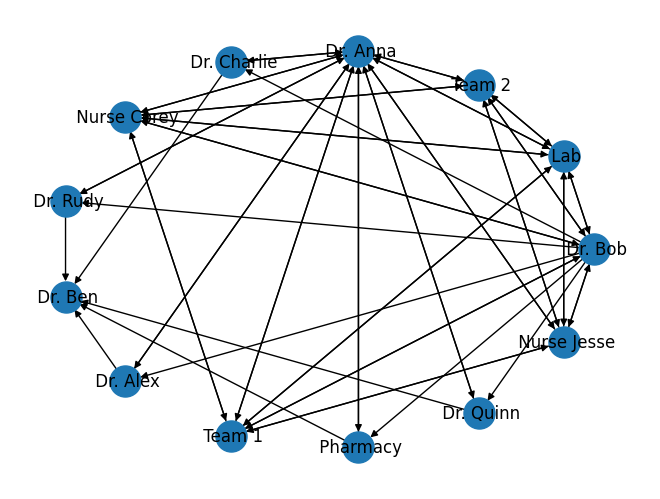

In [343]:
from pm4py import discover_handover_of_work_network, view_sna

net = discover_handover_of_work_network(log_csv)
view_sna(net, variant_str='networkx')
plt.show()

**Задание. Обнаружение модели процессов**

**1. По имеющемуся набору данных постройте модель процессов используя различные алгоритмы обнаружения процесса: inductive miner, heuristics miner, Alpha Miner, DFG граф.**

**Для inductive miner**

In [344]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.convert import convert_to_petri_net as pt_converter

tree = inductive_miner.apply(event_log)

net, initial_marking, final_marking = pt_converter(tree)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

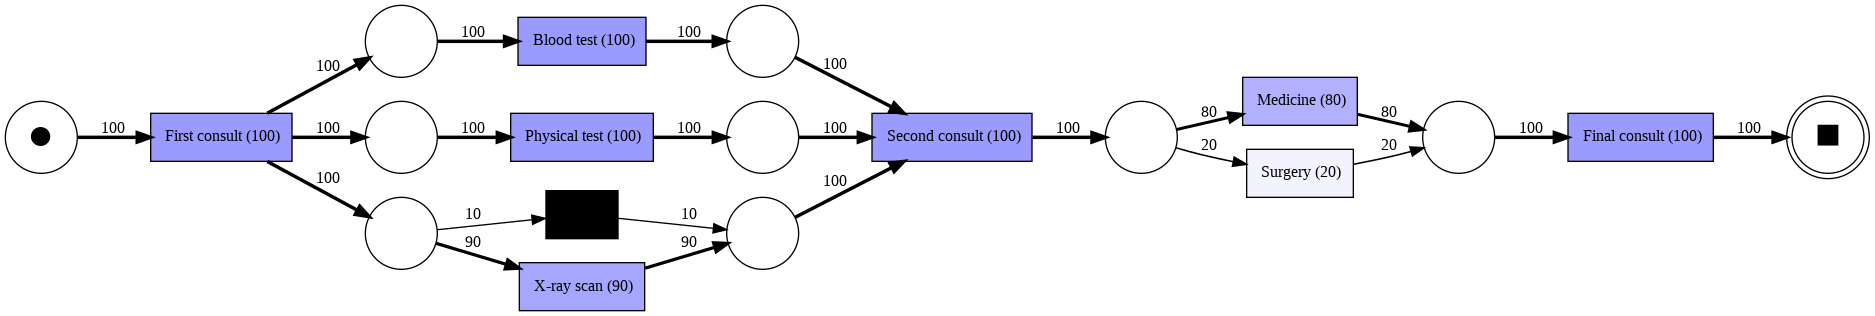

In [345]:
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=event_log,)
pn_visualizer.view(gviz)

In [346]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator

simplicity_ind = simplicity_evaluator.apply(net)
print(f"Простота: {simplicity_ind}\n")

fitness_ind = replay_fitness_evaluator.apply(event_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED,)
print(f"Пригодность воспроизведения (метод на основе токенов): {fitness_ind}\n")

prec_ind = precision_evaluator.apply(event_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN,)
print(f"\nТочность (метод ETConformance): {prec_ind}\n")

gen_ind = generalization_evaluator.apply(event_log, net, initial_marking, final_marking,)
print(f"\nОбобщение: {gen_ind}\n")

Простота: 0.7599999999999999



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

Пригодность воспроизведения (метод на основе токенов): {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}



replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность (метод ETConformance): 0.9840848806366048



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение: 0.8603280868910275



**Для heuristics miner**

In [347]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

net, initial_marking, final_marking = heuristics_miner.apply(event_log)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

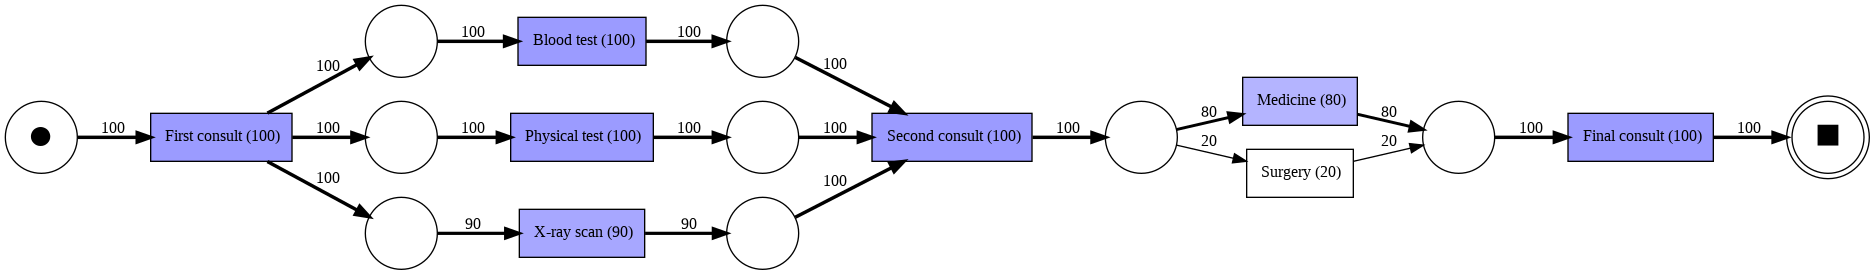

In [348]:
gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=event_log,)
pn_visualizer.view(gviz)

In [349]:
simplicity_heu = simplicity_evaluator.apply(net)
print(f"Простота равна: {simplicity_heu}\n")

fitness_heu = replay_fitness_evaluator.apply(event_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED,)
print(f"Пригодность воспроизведения (метод на основе токенов): {fitness_heu}\n")

prec_heu = precision_evaluator.apply(event_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN,)
print(f"\nТочность (метод ETConformance): {prec_heu}\n")

gen_heu = generalization_evaluator.apply(event_log, net, initial_marking, final_marking,)
print(f"\nОбобщение: {gen_heu}\n")

Простота равна: 0.8181818181818181



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

Пригодность воспроизведения (метод на основе токенов): {'perc_fit_traces': 90.0, 'average_trace_fitness': 0.9888888888888888, 'log_fitness': 0.98989898989899, 'percentage_of_fitting_traces': 90.0}



replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность (метод ETConformance): 0.9830188679245283



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение: 0.8823975685045107



**Для Alpha Miner**

In [350]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

net, initial_marking, final_marking = alpha_miner.apply(event_log)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

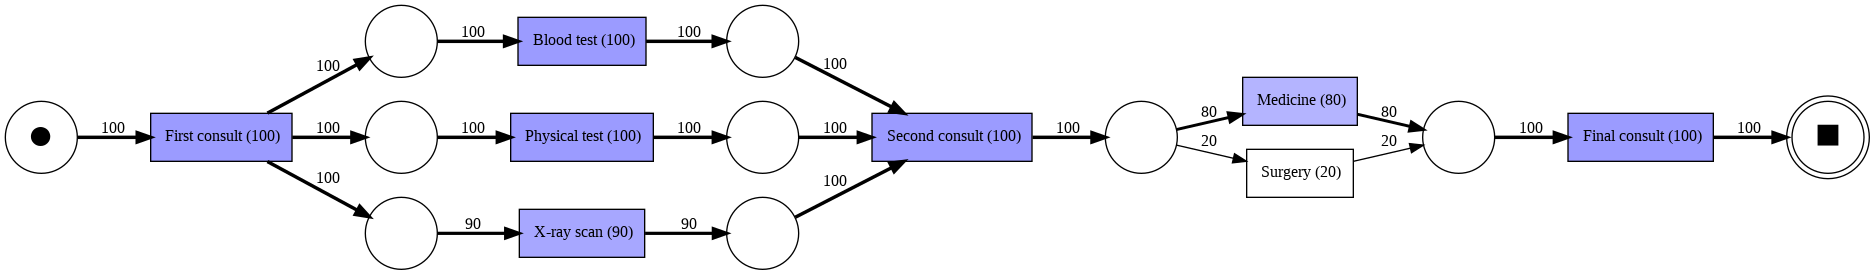

In [351]:
gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=event_log,)
pn_visualizer.view(gviz)

In [352]:
simplicity_alp = simplicity_evaluator.apply(net)
print(f"Простота: {simplicity_alp}\n")

fitness_alp = replay_fitness_evaluator.apply(event_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED,)
print(f"Пригодность воспроизведения (метод на основе токенов): {fitness_alp}\n")

prec_alp = precision_evaluator.apply(event_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN,)
print(f"\nТочность (метод ETConformance): {prec_alp}\n")

gen_alp = generalization_evaluator.apply(event_log, net, initial_marking, final_marking,)
print(f"\nОбобщение: {gen_alp}\n")

Простота: 0.8181818181818181



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

Пригодность воспроизведения (метод на основе токенов): {'perc_fit_traces': 90.0, 'average_trace_fitness': 0.9888888888888888, 'log_fitness': 0.98989898989899, 'percentage_of_fitting_traces': 90.0}



replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность (метод ETConformance): 0.9830188679245283



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение: 0.8823975685045107



**Для DFG граф**

In [353]:
from pm4py.algo.discovery.dfg import algorithm as dfg_graph
from pm4py.objects.conversion.dfg import converter as dfg_mining
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

dfg = dfg_graph.apply(event_log)
net, initial_marking, final_marking = dfg_mining.apply(dfg)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

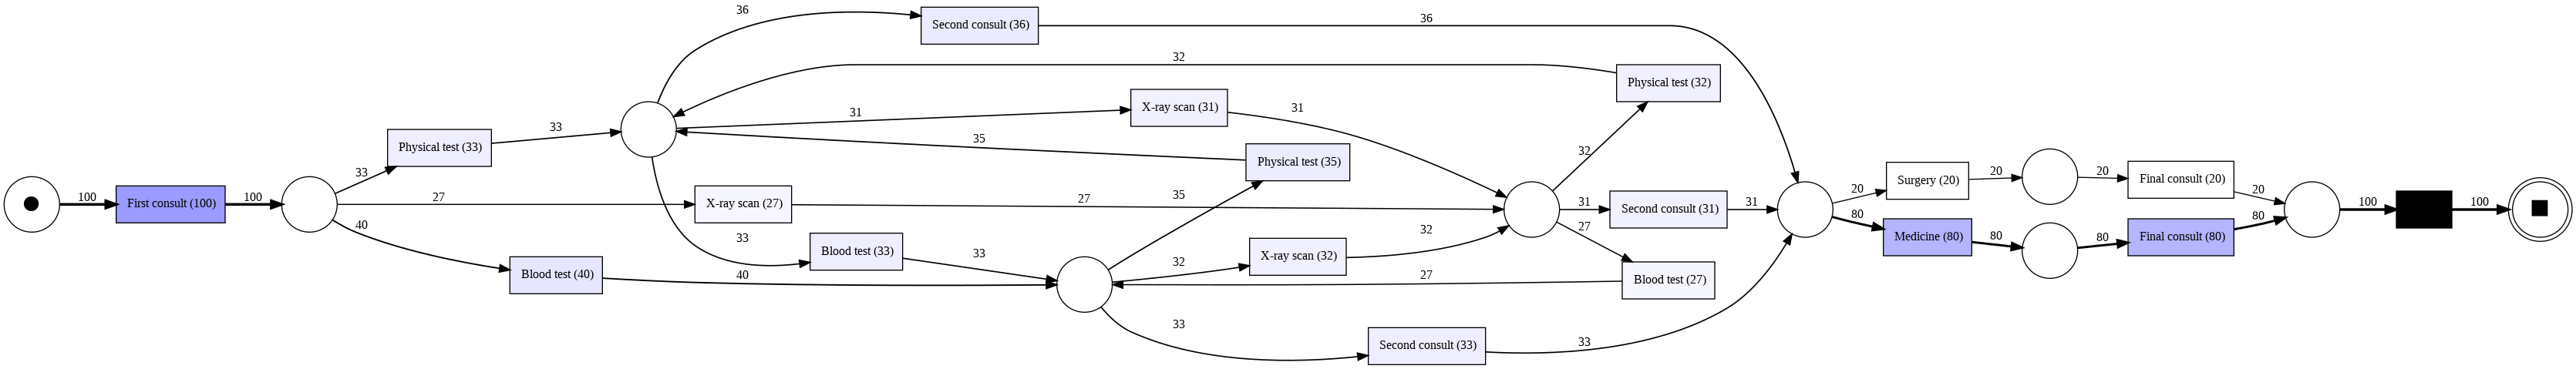

In [354]:
gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters, log=event_log, variant=pn_visualizer.Variants.FREQUENCY,)
pn_visualizer.view(gviz)

In [355]:
simplicity_dfg = simplicity_evaluator.apply(net)
print(f"Простота: {simplicity_dfg}\n")

fitness_dfg = replay_fitness_evaluator.apply(event_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED,)
print(f"Пригодность воспроизведения (метод на основе токенов): {fitness_dfg}\n")

prec_dfg = precision_evaluator.apply(event_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN,)
print(f"\nТочность (метод ETConformance): {prec_dfg}\n")

gen_dfg = generalization_evaluator.apply(event_log, net, initial_marking, final_marking,)
print(f"\nОбобщение: {gen_dfg}\n")

Простота: 0.6363636363636362



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

Пригодность воспроизведения (метод на основе токенов): {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}



replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность (метод ETConformance): 0.7089171974522293



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение: 0.8341928368975338



Сравним полученные метрики.

**1. Простота.** Видно, что данная метрика наиболее высокая у heuristics miner и  alpha miner.

In [356]:
from tabulate import tabulate

mydata1 = [["inductive miner", simplicity_ind], ["heuristics miner", simplicity_heu], ["alpha miner", simplicity_alp], ["DFG", simplicity_dfg]]
head1 = ["Algorithm", "Simplicity"]
print(tabulate(mydata1, headers=head1, tablefmt="grid"))

+------------------+--------------+
| Algorithm        |   Simplicity |
+==================+==============+
| inductive miner  |     0.76     |
+------------------+--------------+
| heuristics miner |     0.818182 |
+------------------+--------------+
| alpha miner      |     0.818182 |
+------------------+--------------+
| DFG              |     0.636364 |
+------------------+--------------+


**2. Пригодность воспроизведения.** Наибольшая пригодность = 1 у inductive miner и DFG.

In [357]:
mydata2 = [["inductive miner", fitness_ind['average_trace_fitness']], ["heuristics miner", fitness_heu['average_trace_fitness']], ["alpha miner", fitness_alp['average_trace_fitness']], ["DFG", fitness_dfg['average_trace_fitness']]]
head2 = ["Algorithm", "Fitness"]
print(tabulate(mydata2, headers=head2, tablefmt="grid"))

+------------------+-----------+
| Algorithm        |   Fitness |
+==================+===========+
| inductive miner  |  1        |
+------------------+-----------+
| heuristics miner |  0.988889 |
+------------------+-----------+
| alpha miner      |  0.988889 |
+------------------+-----------+
| DFG              |  1        |
+------------------+-----------+


**3. Точность.** Наивысшая точность у inductive miner.

In [358]:
mydata3 = [["inductive miner", prec_ind], ["heuristics miner", prec_heu], ["alpha miner", prec_alp], ["DFG", prec_dfg]]
head3 = ["Algorithm", "Precision"]
print(tabulate(mydata3, headers=head3, tablefmt="grid"))

+------------------+-------------+
| Algorithm        |   Precision |
+==================+=============+
| inductive miner  |    0.984085 |
+------------------+-------------+
| heuristics miner |    0.983019 |
+------------------+-------------+
| alpha miner      |    0.983019 |
+------------------+-------------+
| DFG              |    0.708917 |
+------------------+-------------+


**4. Обощение.** Наибольшее значение метрики у heuristics miner и alpha miner.

In [359]:
mydata4 = [["inductive miner", gen_ind], ["heuristics miner", gen_heu], ["alpha miner", gen_alp], ["DFG", gen_dfg]]
head4 = ["Algorithm", "Generalization"]
print(tabulate(mydata4, headers=head4, tablefmt="grid"))

+------------------+------------------+
| Algorithm        |   Generalization |
+==================+==================+
| inductive miner  |         0.860328 |
+------------------+------------------+
| heuristics miner |         0.882398 |
+------------------+------------------+
| alpha miner      |         0.882398 |
+------------------+------------------+
| DFG              |         0.834193 |
+------------------+------------------+


Достаточно сложно сделать определенный вывод касательно того, какая из моделей больше подходит для применения в данной задаче, так как метрики моделей inductive miner, heuristics miner и alpha miner находятся примерно на одном уровне, в какой-то метрике уступая другим, а в какой-то выигрывая.

Однако можно предположить, что DFG граф наименее подходящая в данном случае модель, так как она уступает всем остальным моделям по всем метрикам, кроме Fitness.